# Crossover in P1 Problem

## Problem P1 — Continuous Coverage with Mobility

Problem P1 addresses the continuous deployment of relay nodes in a wireless sensor network over a bounded planar region $\Omega \subset \mathbb{R}^2$, under the presence of mobile nodes with predefined trajectories.

The decision variables consist of the continuous spatial positions of a fixed number of relay nodes, each constrained to lie within $\Omega$. Mobile nodes are modeled by continuous time-dependent trajectories, inducing a dynamic coverage and communication pattern over the region.

The objective is to optimize a vector of performance metrics—such as coverage quality, energy consumption, latency, and network connectivity—evaluated through realistic network simulation. The problem is inherently multi-objective, nonlinear, and constrained, with feasibility requiring that all deployed nodes remain within $\Omega$ and that global network connectivity is preserved throughout the considered time horizon.



## Util Methods

In [15]:
import random
import math
import numpy as np
from collections import deque

def network_gen(
    amount: int,
    region: tuple[float, float, float, float],
    radius: float,
    max_attempts: int = 100
) -> list[tuple[float, float]]:
    """
    Generates random points, maximizing region coverage and ensuring the graph is connected.

    Parameters:
    - amount: number of points to be generated
    - region: (x_min, y_min, x_max, y_max) defining the rectangular region
    - radius: radius of connection between points
    - max_attempts: maximum number of attempts to find a valid position for each point

    Returns:
    - list of coordinates of the generated points
    """

    if amount <= 0:
        return []

    x_min, y_min, x_max, y_max = region
    points: list[tuple[float, float]] = []

    # First point in the center of the region
    first_x = (x_min + x_max) / 2
    first_y = (y_min + y_max) / 2
    points.append((first_x, first_y))

    def is_connected(points: list[tuple[float, float]], radius: float) -> bool:
        if not points:
            return True
        visited: set[int] = set()
        queue: deque[int] = deque([0])
        adjacency: dict[int, list[int]] = {i: [] for i in range(len(points))}

        for i in range(len(points)):
            for j in range(i + 1, len(points)):
                if math.dist(points[i], points[j]) <= radius:
                    adjacency[i].append(j)
                    adjacency[j].append(i)

        while queue:
            node = queue.popleft()
            if node not in visited:
                visited.add(node)
                queue.extend(adjacency[node])

        return len(visited) == len(points)

    while len(points) < amount:
        best_point: tuple[float, float] = None
        max_min_distance = 0.0

        for _ in range(max_attempts):
            anchor_idx = random.choice(range(len(points)))
            anchor = points[anchor_idx]

            angle = random.uniform(0, 2 * math.pi)
            distance = random.uniform(0.5 * radius, radius)

            new_x = anchor[0] + distance * math.cos(angle)
            new_y = anchor[1] + distance * math.sin(angle)

            if not (x_min <= new_x <= x_max and y_min <= new_y <= y_max):
                continue

            temp_points = points + [(new_x, new_y)]

            if is_connected(temp_points, radius):
                min_dist = min(math.dist((new_x, new_y), p) for p in points)
                if min_dist > max_min_distance:
                    max_min_distance = min_dist
                    best_point = (new_x, new_y)

        if best_point:
            points.append(best_point)
        else:
            if len(points) > 1:
                components: list[list[int]] = []
                visited: set[int] = set()
                for i in range(len(points)):
                    if i not in visited:
                        component: list[int] = []
                        queue: deque[int] = deque([i])
                        while queue:
                            node = queue.popleft()
                            if node not in visited:
                                visited.add(node)
                                component.append(node)
                                for j in range(len(points)):
                                    if j != node and math.dist(points[node], points[j]) <= radius:
                                        queue.append(j)
                        components.append(component)

                if len(components) > 1:
                    comp1, comp2 = random.sample(components, 2)
                    point1 = points[random.choice(comp1)]
                    point2 = points[random.choice(comp2)]

                    mid_x = (point1[0] + point2[0]) / 2
                    mid_y = (point1[1] + point2[1]) / 2
                    direction = math.atan2(point2[1] - point1[1], point2[0] - point1[0])

                    new_x = mid_x + random.uniform(-0.3 * radius, 0.3 * radius) * math.sin(direction)
                    new_y = mid_y + random.uniform(-0.3 * radius, 0.3 * radius) * math.cos(direction)

                    new_x = float(np.clip(new_x, x_min, x_max))
                    new_y = float(np.clip(new_y, y_min, y_max))

                    points.append((new_x, new_y))
                    continue

            anchor = random.choice(points)
            angle = random.uniform(0, 2 * math.pi)
            distance = random.uniform(0, radius)
            new_x = anchor[0] + distance * math.cos(angle)
            new_y = anchor[1] + distance * math.sin(angle)

            new_x = float(np.clip(new_x, x_min, x_max))
            new_y = float(np.clip(new_y, y_min, y_max))
            points.append((new_x, new_y))

    # Final connectivity check
    if not is_connected(points, radius):
        components: list[list[int]] = []
        visited: set[int] = set()
        for i in range(len(points)):
            if i not in visited:
                component: list[int] = []
                queue: deque[int] = deque([i])
                while queue:
                    node = queue.popleft()
                    if node not in visited:
                        visited.add(node)
                        component.append(node)
                        for j in range(len(points)):
                            if j != node and math.dist(points[node], points[j]) <= radius:
                                queue.append(j)
                components.append(component)

        while len(components) > 1:
            comp1, comp2 = random.sample(components, 2)
            point1 = points[random.choice(comp1)]
            point2 = points[random.choice(comp2)]

            mid_x = (point1[0] + point2[0]) / 2
            mid_y = (point1[1] + point2[1]) / 2
            points.append((mid_x, mid_y))

            # Recalcular componentes
            components = []
            visited = set()
            for i in range(len(points)):
                if i not in visited:
                    component: list[int] = []
                    queue: deque[int] = deque([i])
                    while queue:
                        node = queue.popleft()
                        if node not in visited:
                            visited.add(node)
                            component.append(node)
                            for j in range(len(points)):
                                if j != node and math.dist(points[node], points[j]) <= radius:
                                    queue.append(j)
                    components.append(component)

    return points


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Circle

def plot_network(
    points: list[tuple[float, float]],
    region: tuple[float, float, float, float],
    radius: float
    ) -> None:

    _, ax = plt.subplots(figsize=(10, 8))

    ax.set_xlim(region[0], region[2])
    ax.set_ylim(region[1], region[3])
    ax.set_aspect("equal")
    ax.grid(True, linestyle="--", alpha=0.7)
    ax.set_title(
        f"Rede com {len(points)} nós "
        f"(raio comunicação = {radius}"
    )

    ax.add_patch(
        plt.Rectangle(
            (region[0], region[1]),
            region[2] - region[0],
            region[3] - region[1],
            fill=False,
            linestyle="--",
            edgecolor="red",
            linewidth=1,
        )
    )

    # Communication edges
    for i in range(len(points)):
        for j in range(i + 1, len(points)):
            d = np.hypot(points[i][0] - points[j][0],
                         points[i][1] - points[j][1])
            if d <= radius:
                ax.plot(
                    [points[i][0], points[j][0]],
                    [points[i][1], points[j][1]],
                    color="#EE0A0A",
                    linewidth=1,
                    alpha=0.7,
                )

    # Communication disks
    for (x, y) in points:
        ax.add_patch(
            Circle(
                (x, y),
                radius,
                facecolor="#4ECDC4",   # verde-água
                edgecolor="green",
                alpha=0.35,
                linewidth=1.0,
            )
        )

    # Nodes (markers)
    for i, (x, y) in enumerate(points):
        ax.plot(x, y, "o", markersize=8, color="gray")
        ax.text(x, y, str(i+1), color="black",
                ha="center", va="center", fontsize=8)

    plt.show()

In [17]:
from collections import defaultdict, deque
import math


def is_globally_connected(
    positions: list[tuple[float,float]],
    radius: float
) -> bool:
    points: list[tuple[float,float]] = list(positions)
    n = len(points)

    if n == 0:
        return False
    if n == 1:
        return True

    radius_sq = radius * radius
    cell_size = radius

    # --------------------------------------------------
    # 1. Spatial hashing: build uniform grid
    # --------------------------------------------------
    grid: dict[tuple[int, int], list[int]] = defaultdict(list)

    for idx, (x, y) in enumerate(points):
        cell = (
            int(math.floor(x / cell_size)),
            int(math.floor(y / cell_size))
        )
        grid[cell].append(idx)

    # --------------------------------------------------
    # 2. BFS over the implicit geometric graph
    # --------------------------------------------------
    visited = set()
    queue = deque([0])
    visited.add(0)

    while queue:
        i = queue.popleft()
        xi, yi = points[i]

        cx = int(math.floor(xi / cell_size))
        cy = int(math.floor(yi / cell_size))

        # Check current cell and the 8 neighbors
        for dx in (-1, 0, 1):
            for dy in (-1, 0, 1):
                neighbor_cell = (cx + dx, cy + dy)

                for j in grid.get(neighbor_cell, []):
                    if j in visited or j == i:
                        continue

                    xj, yj = points[j]
                    dx_ = xi - xj
                    dy_ = yi - yj

                    if dx_ * dx_ + dy_ * dy_ <= radius_sq:
                        visited.add(j)
                        queue.append(j)

    return len(visited) == n


## Crossover Analysis 

### Simulated Binary Crossover SBX

The crossover operation between two individuals 
$\mathbf{p}_1 = (p_{1,1}, p_{1,2}, \ldots, p_{1,n})$ and 
$\mathbf{p}_2 = (p_{2,1}, p_{2,2}, \ldots, p_{2,n})$ 
is defined by the generation of two offspring individuals 
$\mathbf{c}_1$ and $\mathbf{c}_2$, according to the following equation:

$$
\beta =
\begin{cases}
(2u)^{\frac{1}{\eta + 1}}, & \text{if } u < \frac{1}{2}, \\
\big(2(1 - u)\big)^{-\frac{1}{\eta + 1}}, & \text{if } u \ge \frac{1}{2},
\end{cases}
\quad \text{where } u \sim U(0, 1).
$$

For each coordinate $i$ of the individuals:

$$
c_{1,i} = \frac{1}{2} \big( (1 + \alpha)p_{1,i} + (1 - \alpha)p_{2,i} \big),
$$
$$
c_{2,i} = \frac{1}{2} \big( (1 - \alpha)p_{1,i} + (1 + \alpha)p_{2,i} \big).
$$

After computing $c_{1,i}$ and $c_{2,i}$, the resulting values are clipped to the bounds $[l_i, u_i]$:

$$
c_{1,i} = \min\big(\max(c_{1,i}, l_i), u_i\big)
\quad \text{and} \quad
c_{2,i} = \min\big(\max(c_{2,i}, l_i), u_i\big).
$$

*Referência*: [K-Bit-Swap: A New Operator For Real-Coded Evolutionary Algorithms](https://arxiv.org/pdf/1604.06607)


In [18]:
import math
import random

def sbx(p1: float, p2: float, 
        rng: random.Random,
        eta: float, 
        bounds: tuple[float,float]
        ) -> tuple[float, float]:    
    if eta <= 0:
        raise ValueError("eta must be > 0 for SBX.")
    
    x1, x2 = p1, p2

    # If genes are (almost) identical, nothing to mix
    if abs(x1 - x2) < 1e-14:
        c1, c2 = x1, x2
        return c1, c2

    # Optional bounds
    if bounds is not None:
        xl, xu = bounds
    else:
        xl, xu = -math.inf, math.inf

    # Ensure y1 <= y2 for formula
    if x1 > x2:
        y1, y2 = x2, x1
        swap = True
    else:
        y1, y2 = x1, x2
        swap = False

    rand = rng.random()
    beta = 1.0 + 2.0 * (y1 - xl) / (y2 - y1) if math.isfinite(xl) else 1.0
    alpha = 2.0 - pow(beta, -(eta + 1.0)) if beta > 0 else 1.0

    if rand <= 1.0 / alpha:
        betaq = pow(rand * alpha, 1.0 / (eta + 1.0))
    else:
        betaq = pow(1.0 / (2.0 - rand * alpha), 1.0 / (eta + 1.0))

    child1 = 0.5 * ((y1 + y2) - betaq * (y2 - y1))
    child2 = 0.5 * ((y1 + y2) + betaq * (y2 - y1))

    # Clip to bounds if provided
    child1 = min(max(child1, xl), xu)
    child2 = min(max(child2, xl), xu)

    # Randomly swap assignment to increase diversity
    if rng.random() < 0.5:
        child1, child2 = child2, child1

    # Restore original order of parents
    if swap:
        c1, c2 = child2, child1
    else:
        c1, c2 = child1, child2

    return c1, c2

Instance Problem

In [19]:
REGION = (-250, -250, 250, 250)
RADIUS = 100
AMOUNT = 15

Generate Random Parents

is globally connected: True


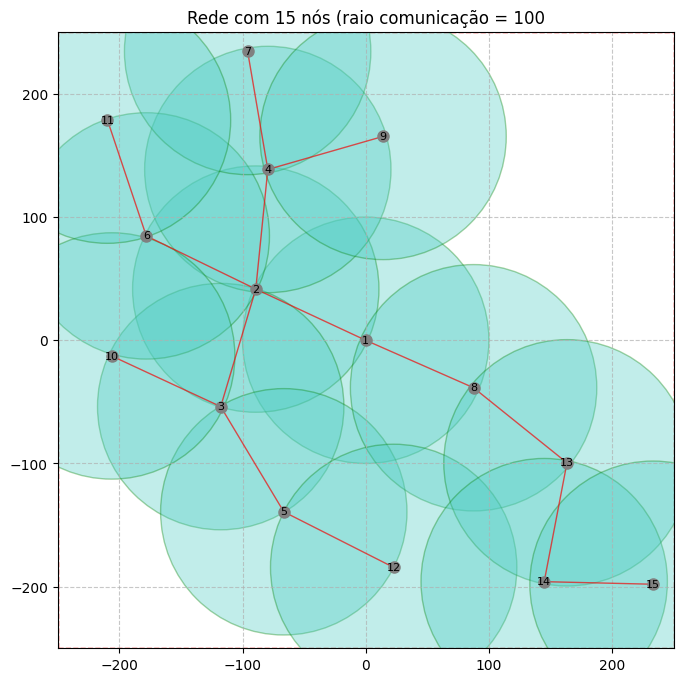

In [20]:
P1 = network_gen(AMOUNT, REGION, RADIUS)
print("is globally connected:", is_globally_connected(P1, RADIUS))
plot_network(P1, REGION, RADIUS)

is globally connected: True


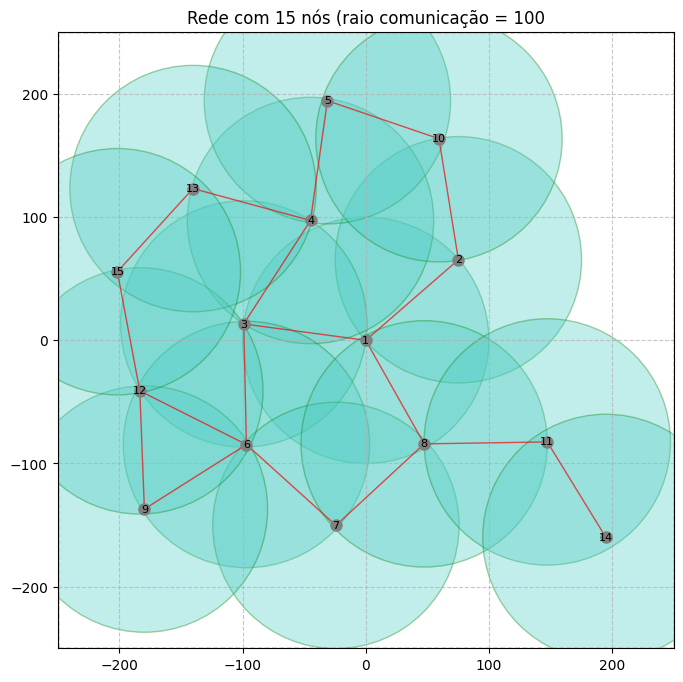

In [21]:
P2 = network_gen(AMOUNT, REGION, RADIUS)
print("is globally connected:", is_globally_connected(P2, RADIUS))
plot_network(P2, REGION, RADIUS)

Only apply SBX

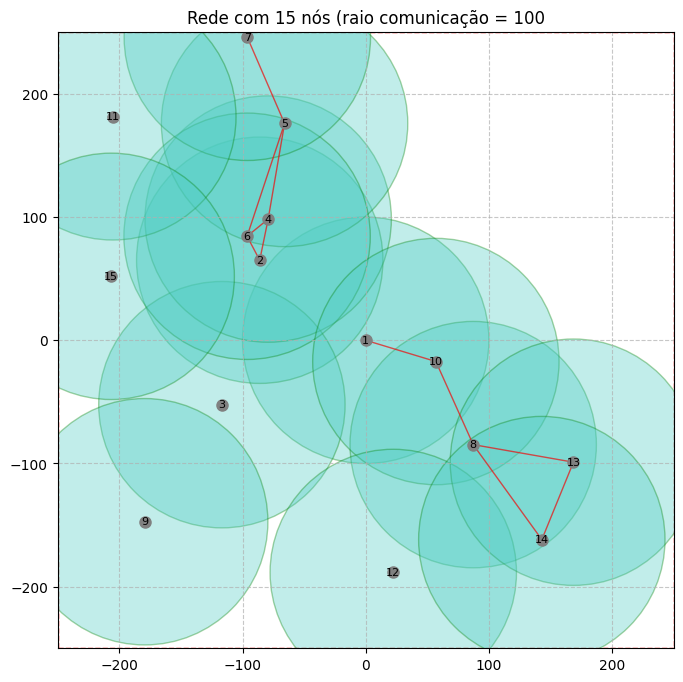

is globally connected: False


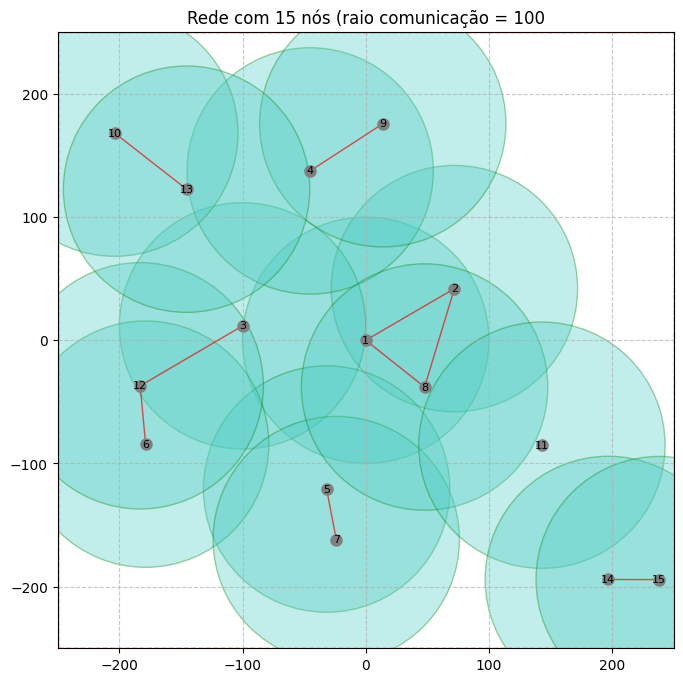

is globally connected: False


In [22]:
import random

ETA = 20

rng = random.Random()

c1: list[tuple[float,float]] = []
c2: list[tuple[float,float]] = []

x_min, y_min, x_max, y_max = tuple(REGION)

for (x1, y1), (x2, y2) in zip(P1, P2):
    # Apply SBX independently to x and y
    cx1, cx2 = sbx(x1, x2, rng, ETA, (x_min, x_max))
    cy1, cy2 = sbx(y1, y2, rng, ETA, (y_min, y_max))

    c1.append((cx1, cy1))
    c2.append((cx2, cy2))
    
plot_network(c1, REGION, RADIUS)
print("is globally connected:", is_globally_connected(c1, RADIUS))
plot_network(c2, REGION, RADIUS)
print("is globally connected:", is_globally_connected(c2, RADIUS))

The central point is: SBX does not respect topological structure, and in its case, global connectivity is not a continuous property of the search space. Therefore, pure rejection tends to fail.

### SBX + Connectivity by contraction 

In [23]:
import math

Point = tuple[float, float]


def dist(p: Point, q: Point) -> float:
    return math.hypot(p[0] - q[0], p[1] - q[1])


def connected_components(points: list[Point], radius: float) -> list[list[int]]:
    """
    Retorna as componentes conexas como listas de índices.
    """
    n = len(points)
    visited = [False] * n
    adj = [[] for _ in range(n)]

    for i in range(n):
        for j in range(i + 1, n):
            if dist(points[i], points[j]) <= radius:
                adj[i].append(j)
                adj[j].append(i)

    components = []

    for i in range(n):
        if not visited[i]:
            stack = [i]
            visited[i] = True
            comp = []

            while stack:
                u = stack.pop()
                comp.append(u)
                for v in adj[u]:
                    if not visited[v]:
                        visited[v] = True
                        stack.append(v)

            components.append(comp)

    return components


def translate_component(
    points: list[Point],
    component: list[int],
    direction: tuple[float, float],
    delta: float
) -> None:
    """
    Move uma componente inteira ao longo de um vetor unitário 'direction'.
    """
    dx = direction[0] * delta
    dy = direction[1] * delta

    for i in component:
        x, y = points[i]
        points[i] = (x + dx, y + dy)


def make_graph_connected(
    points: list[Point],
    radius: float,
    step: float = 0.1
) -> list[Point]:
    """
    Modifica as posições dos pontos até que o grafo fique conexo,
    preservando a geometria interna das componentes.
    """
    points = points.copy()
    root = points[0]

    while True:
        components = connected_components(points, radius)

        # Se já é conexo
        if len(components) == 1:
            break

        # Identifica componente da raiz
        root_comp = None
        for comp in components:
            if 0 in comp:
                root_comp = comp
                break

        assert root_comp is not None

        # Processa uma componente externa por vez
        for comp in components:
            if comp is root_comp:
                continue

            # Escolhe um ponto qualquer da componente
            idx = comp[0]
            px, py = points[idx]

            # Direção radial para a raiz
            vx = root[0] - px
            vy = root[1] - py
            norm = math.hypot(vx, vy)
            direction = (vx / norm, vy / norm)

            # Move incrementalmente até conectar
            while True:
                translate_component(points, comp, direction, step)

                # Testa se houve conexão
                for i in comp:
                    for j in root_comp:
                        if dist(points[i], points[j]) <= radius:
                            break
                    else:
                        continue
                    break
                else:
                    continue

                break

            break  # reavaliar componentes após cada conexão

    return points

Apply SBX + connectivity by radial contraction

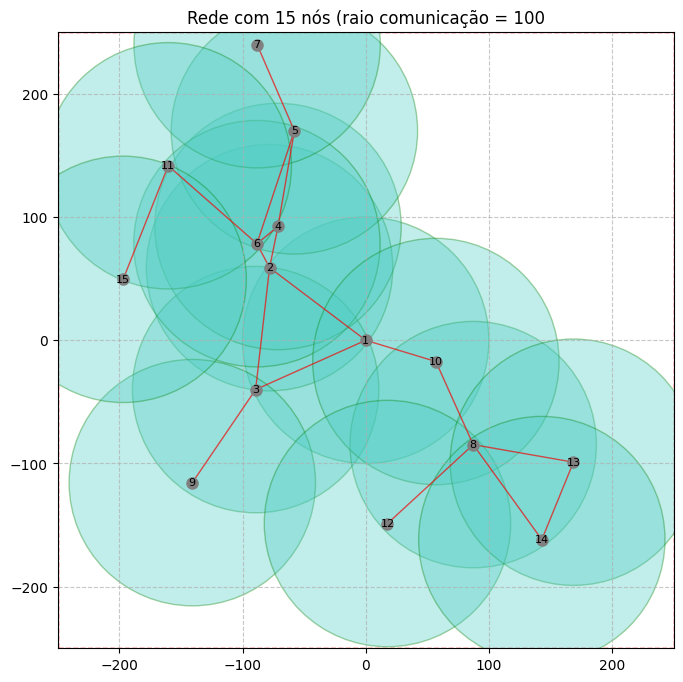

is globally connected: True


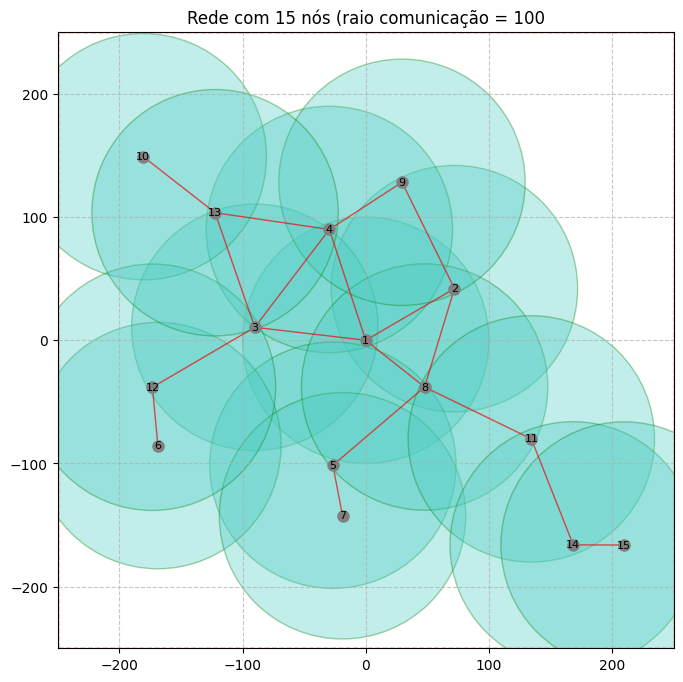

is globally connected: True


In [24]:
a1 = make_graph_connected(c1, RADIUS, step=10)
a2 = make_graph_connected(c2, RADIUS, step=10)
plot_network(a1, REGION, RADIUS)
print("is globally connected:", is_globally_connected(a1, RADIUS))
plot_network(a2, REGION, RADIUS)
print("is globally connected:", is_globally_connected(a2, RADIUS))

### Minimum Spanning Tree (MST) based Crossover

In [27]:
import random
import numpy as np
import networkx as nx


def build_graph(points, radius):
    G = nx.Graph()
    for i, p in enumerate(points):
        G.add_node(i, pos=p)

    for i in range(len(points)):
        for j in range(i + 1, len(points)):
            d = np.linalg.norm(np.array(points[i]) - np.array(points[j]))
            if d <= radius:
                G.add_edge(i, j, weight=d)

    if not nx.is_connected(G):
        raise ValueError("Parent is not globally connected")

    return G


def build_mst(points, radius):
    G = build_graph(points, radius)
    return nx.minimum_spanning_tree(G)


def mst_structural_crossover(T1, T2, rng):
    nodes = list(T1.nodes)
    rng.shuffle(nodes)

    cut = rng.randint(1, len(nodes) - 1)
    inherited = set(nodes[:cut])

    edges = set()

    # keep edges fully inside inherited subset (from T1)
    for u, v in T1.edges:
        if u in inherited and v in inherited:
            edges.add((u, v))

    # add edges from T2 to reconnect the rest
    for u, v in T2.edges:
        if (u not in inherited) or (v not in inherited):
            edges.add((u, v))

    return edges


def embed_from_tree_1(edges, parent_points, radius, np_rng, sigma=0.05):
    """
    Geometric embedding that preserves connectivity by construction.
    Node 0 is kept fixed (anchor).
    """
    points = list(parent_points)
    visited = set()

    # FIXED ROOT (anchor node)
    root = 0
    visited.add(root)
    stack = [root]

    adjacency = {}
    for u, v in edges:
        adjacency.setdefault(u, []).append(v)
        adjacency.setdefault(v, []).append(u)

    while stack:
        u = stack.pop()
        for v in adjacency.get(u, []):
            if v in visited:
                continue

            pu = np.array(points[u])

            direction = np_rng.normal(0.0, 1.0, size=2)
            direction /= np.linalg.norm(direction)

            length = np_rng.uniform(0.6 * radius, 0.9 * radius)
            noise = np_rng.normal(0.0, sigma, size=2)

            pv = pu + length * direction + noise

            points[v] = tuple(pv)
            visited.add(v)
            stack.append(v)

    return points


def embed_from_tree(
    edges,
    parent_points,
    radius,
    np_rng,
    sigma=0.02,
    repulsion=0.3,
    anchor=0
):
    """
    Connectivity-preserving embedding with spatial expansion.
    The anchor node is kept fixed.
    """
    points = list(parent_points)
    visited = {anchor}
    stack = [anchor]

    adjacency = {}
    for u, v in edges:
        adjacency.setdefault(u, []).append(v)
        adjacency.setdefault(v, []).append(u)

    while stack:
        u = stack.pop()
        for v in adjacency.get(u, []):
            if v in visited:
                continue

            pu = np.array(points[u])

            # Direction: random unit vector
            direction = np_rng.normal(0.0, 1.0, size=2)
            direction /= np.linalg.norm(direction)

            # Length biased toward max radius (coverage)
            length = np_rng.uniform(0.85 * radius, 0.98 * radius)

            pv = pu + length * direction

            # --- Repulsion from already placed nodes ---
            if len(visited) > 1:
                repel = np.zeros(2)
                for w in visited:
                    pw = np.array(points[w])
                    diff = pv - pw
                    d = np.linalg.norm(diff)
                    if d > 1e-6:
                        repel += diff / (d ** 2)
                repel /= len(visited)
                pv += repulsion * repel

            # Small noise to avoid degeneracy
            pv += np_rng.normal(0.0, sigma, size=2)

            points[v] = tuple(pv)
            visited.add(v)
            stack.append(v)

    return points



def mst_based_crossover(P1, P2, REGION, RADIUS, rng, np_rng):
    """
    Connectivity-preserving MST-based crossover.
    """
    # Build MSTs
    T1 = build_mst(P1, RADIUS)
    T2 = build_mst(P2, RADIUS)

    # Structural crossover
    edges1 = mst_structural_crossover(T1, T2, rng)
    edges2 = mst_structural_crossover(T2, T1, rng)

    # Geometric embedding
    c1 = embed_from_tree(edges1, P1, RADIUS, np_rng)
    c2 = embed_from_tree(edges2, P2, RADIUS, np_rng)

    return c1, c2


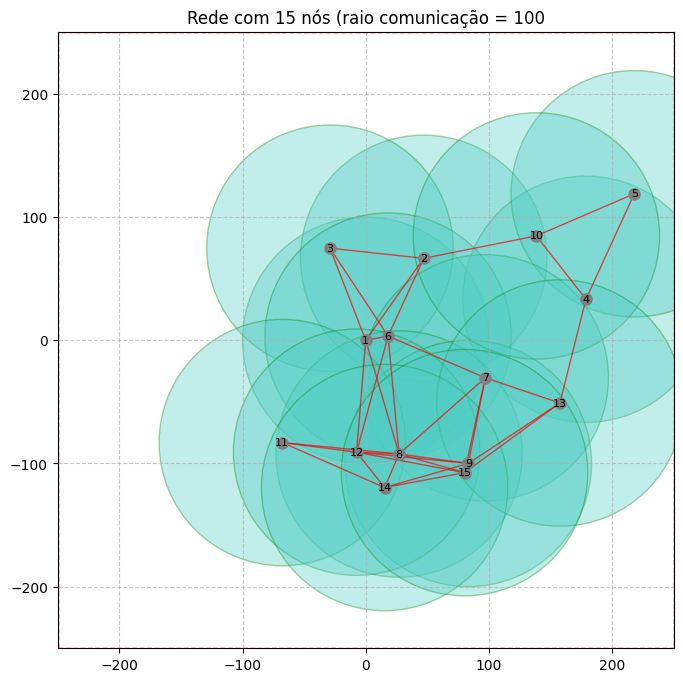

c1 connected: True


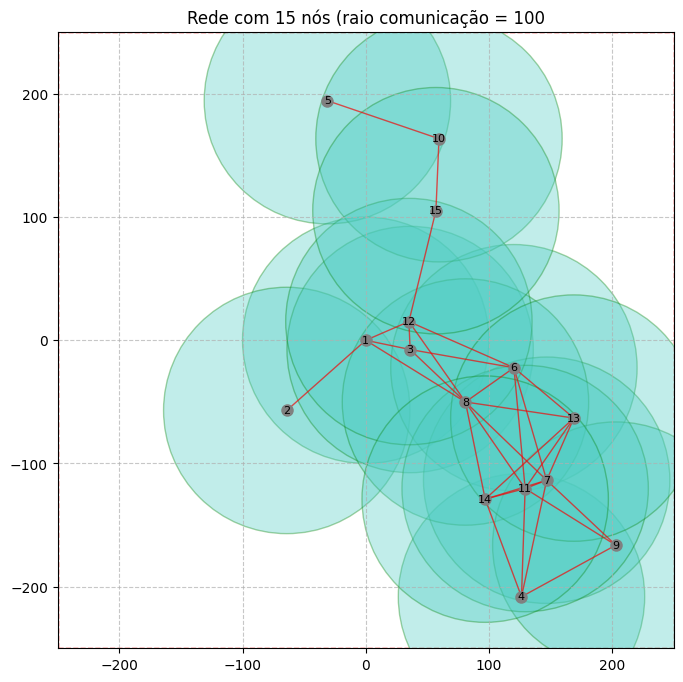

c2 connected: True


In [28]:
rng = random.Random(42)
np_rng = np.random.default_rng(42)

c1, c2 = mst_based_crossover(P1, P2, REGION, RADIUS, rng, np_rng)

plot_network(c1, REGION, RADIUS)
print("c1 connected:", is_globally_connected(c1, RADIUS))

plot_network(c2, REGION, RADIUS)
print("c2 connected:", is_globally_connected(c2, RADIUS))
